In [111]:
%load_ext autoreload
%autoreload 2
import os
import time
import pickle
import numpy as np
import pandas as pd
import multiprocess as mp
from IPython.display import HTML, SVG

from pydrake.geometry import MeshcatVisualizerCpp, MeshcatVisualizerParams, Role, StartMeshcat
from pydrake.geometry.optimization import IrisInConfigurationSpace, IrisOptions
from pydrake.multibody.parsing import LoadModelDirectives, Parser, ProcessModelDirectives
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
# from pydrake.solvers.gurobi import GurobiSolver
# from pydrake.solvers.mosek import MosekSolver
from pydrake.solvers import MathematicalProgram
from pydrake.solvers.snopt import SnoptSolver
from pydrake.systems.framework import DiagramBuilder
# from pydrake.planning.common_robotics_utilities import SimpleRRTPlannerState


from gcs.linear import LinearGCS
from gcs.rounding import randomForwardPathSearch
from reproduction.prm_comparison.planning import PRM, BiRRT
from reproduction.prm_comparison.helpers import (
    ForwardKinematics,
    get_traj_length,
    InverseKinematics,
    is_traj_confined,
    make_traj,
    visualize_trajectory,
)
from reproduction.util import *

# GurobiSolver.AcquireLicense()
os.environ['MOSEKLM_LICENSE_FILE'] = 'mosek/mosek.lic'
MosekSolver.AcquireLicense()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RuntimeError: Could not acquire MOSEK license.

In [4]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [5]:
SEED = 17
np.random.seed(SEED)

In [6]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
parser = Parser(plant)
parser.package_map().Add("gcs", GcsDir())

directives_file = FindModelFile("models/iiwa14_spheres_collision_welded_gripper.yaml")
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)
[iiwa, wsg, shelf, binR, binL, table] =  models
 

plant.Finalize()

meshcat_params = MeshcatVisualizerParams()
meshcat_params.delete_on_initialization_event = False
meshcat_params.role = Role.kIllustration
# meshcat_params.role = Role.kProximity
meshcat_cpp = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat, meshcat_params)

diagram = builder.Build()

context = diagram.CreateDefaultContext()
#plant_context = plant.GetMyContextFromRoot(context)
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 =[0, 0.3, 0, -1.8, 0, 1, 1.57]
plant.SetPositions(plant_context, q0)
diagram.Publish(context)

/var/folders/p0/l4__0wtd3j184sv9zspd0qlm0000gn/T/ipykernel_29450/3718143493.py:18: DrakeDeprecationWarning: MeshcatVisualizerCpp has been renamed to MeshcatVisualizer. The deprecated code will be removed from Drake on or after 2022-11-01.
  meshcat_cpp = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat, meshcat_params)


# Generate Iris Regions
### via manual seeds

In [7]:
milestones =  {"Above Shelve": [[0.75, 0, 0.9],    [0, -np.pi, -np.pi/2]],   
                "Top Rack":    [[0.75, 0, 0.67],   [0, -np.pi, -np.pi/2]],   
                "Middle Rack": [[0.75, 0, 0.41],   [0, -np.pi, -np.pi/2]],       
                "Left Bin":    [[0.0,  0.6, 0.22], [np.pi/2, np.pi, 0]], 
                "Right Bin":   [[0.0, -0.6, 0.22], [np.pi/2, np.pi, np.pi]]}


additional_seed_points = {"Front to Shelve":np.array([0, 0.2, 0, -2.09, 0, -0.3, np.pi/2]), 
                          "Left to Shelve": np.array([0.8, 0.7, 0, -1.6, 0, 0, np.pi/2]),
                          "Right to Shelve":np.array([-0.8, 0.7, 0, -1.6, 0, 0, np.pi/2])} 

q0 =[0, 0.3, 0, -1.8, 0, 1, 1.57]
milestone_configurations =  {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in milestones.items()}

seed_points = {**milestone_configurations, **additional_seed_points}

In [52]:
print(type(seed_points))

<class 'dict'>


In [24]:
iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 10
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.01
iris_options.enable_ibex = False
CORE_CNT = mp.cpu_count() # you may edit this

In [27]:
def calcRegion(seed, verbose):
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    plant.SetPositions(plant_context, seed)
    hpoly = IrisInConfigurationSpace(plant, plant_context, iris_options)
    print("Seed:", seed, "\tTime:", time.time() - start_time, flush=True)
    return hpoly

In [34]:
def generateRegions(seed_points, verbose = True):
    seeds = list(seed_points.values()) if type(seed_points) is dict else seed_points
    regions = []
    loop_time = time.time()
#     with mp.Pool(processes = CORE_CNT) as pool:
#         regions = pool.starmap(calcRegion, [[seed, verbose] for seed in seeds])
    regions = [calcRegion(seed, verbose) for seed in seeds]

    
    if verbose:
        print("Loop time:", time.time() - loop_time)
    
    if type(seed_points) is dict:
        return dict(list(zip(seed_points.keys(), regions)))
    
    return regions

In [35]:
regions = generateRegions(seed_points)

Seed: [ 6.41950821e-05  4.71953264e-01 -1.49318242e-04 -6.71673454e-01
  1.85368193e-04  4.26169599e-01  1.57069215e+00] 	Time: 22.524271249771118
Seed: [-1.55038457e-04  3.97272587e-01  2.19576109e-04 -1.36747559e+00
  2.47152850e-04 -1.92951824e-01  1.57046879e+00] 	Time: 77.1456139087677
Seed: [-1.75984695e-04  6.83027947e-01  2.44995700e-04 -1.64782293e+00
  2.09087139e-05 -7.59054535e-01  1.57062627e+00] 	Time: 48.7941951751709
Seed: [ 1.33266562  0.78659315  0.36233843 -1.49165291 -0.31925088  0.92173247
  1.79119041] 	Time: 14.458280086517334
Seed: [-1.33246236  0.78664776 -0.36265619 -1.49165281  0.31953404  0.92178332
  1.350209  ] 	Time: 13.372639894485474
Seed: [ 0.          0.2         0.         -2.09        0.         -0.3
  1.57079633] 	Time: 29.399556875228882
Seed: [ 0.8         0.7         0.         -1.6         0.          0.
  1.57079633] 	Time: 6.099326848983765
Seed: [-0.8         0.7         0.         -1.6         0.          0.
  1.57079633] 	Time: 22.34925389

In [55]:
print(len(regions))

8


## via pre-generated regions

In [22]:
#load regions
with open(os.path.join(GcsDir(), "data/prm_comparison/IRIS.reg"), "rb") as f:
    regions = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/varun/gcs/data/prm_comparison/IRIS.reg'

regions {'Above Shelve': <pydrake.geometry.optimization.HPolyhedron object at 0x14ee4eb70>, 'Top Rack': <pydrake.geometry.optimization.HPolyhedron object at 0x157729c30>, 'Middle Rack': <pydrake.geometry.optimization.HPolyhedron object at 0x1577532f0>, 'Left Bin': <pydrake.geometry.optimization.HPolyhedron object at 0x1106ec070>, 'Right Bin': <pydrake.geometry.optimization.HPolyhedron object at 0x14edd63f0>, 'Front to Shelve': <pydrake.geometry.optimization.HPolyhedron object at 0x156fbffb0>, 'Left to Shelve': <pydrake.geometry.optimization.HPolyhedron object at 0x1577cb0f0>, 'Right to Shelve': <pydrake.geometry.optimization.HPolyhedron object at 0x157a9a130>}


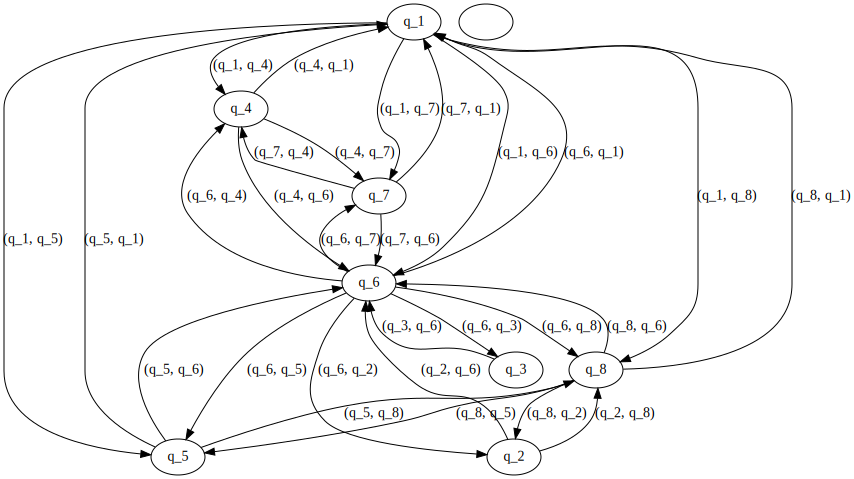

In [54]:
gcs = LinearGCS({f"q_{i + 1}":r for i, r in enumerate(regions.values())})
# print('regions', regions)
SVG(gcs.VisualizeGraph()) 

In [66]:
print(len(gcs.gcs.Edges()))
# print({f"q_{i + 1}":r for i, r in enumerate(regions.values())})

28


# Build PRM

In [ ]:
collision_step_size = 0.02
K = 5
roadmap_size = 15000

#initlize with seeds for fairness
prm = PRM(plant, diagram, collision_step_size, SEED, K, list(seed_points.values()))

### Load Roadmap if you don't want to wait 15 minutes

In [ ]:
#TODO use wget here to download th prm map from server
prm.load(os.path.join(GcsDir(), "data/prm_comparison/15k_presplined.rmp"))

### Or Grow it 

In [ ]:
solve_timeout = 200
goal_bias = 0.05
step_size = 0.1
birrt = BiRRT(plant, diagram, collision_step_size, SEED, step_size, goal_bias, solve_timeout)

### Connect via BiRRT first
Given the knowledge of the Graph of Convex Sets, we will use BiRRT to connect the edges. All of the nodes of the RRT trees will be added to the PRM map

In [ ]:
pairs_2_connect = [
  [SimpleRRTPlannerState(seed_points["Front to Shelve"]), SimpleRRTPlannerState(seed_points["Top Rack"])],
  [SimpleRRTPlannerState(seed_points["Front to Shelve"]), SimpleRRTPlannerState(seed_points["Middle Rack"])],
  [SimpleRRTPlannerState(seed_points["Front to Shelve"]), SimpleRRTPlannerState(seed_points["Left Bin"])],
  [SimpleRRTPlannerState(seed_points["Front to Shelve"]), SimpleRRTPlannerState(seed_points["Right Bin"])],
    
  [SimpleRRTPlannerState(seed_points["Left Bin"]), SimpleRRTPlannerState(seed_points["Above Shelve"])],
  [SimpleRRTPlannerState(seed_points["Left Bin"]), SimpleRRTPlannerState(seed_points["Left to Shelve"])],

    
  [SimpleRRTPlannerState(seed_points["Right Bin"]), SimpleRRTPlannerState(seed_points["Above Shelve"])],
  [SimpleRRTPlannerState(seed_points["Right Bin"]), SimpleRRTPlannerState(seed_points["Right to Shelve"])],
    
  [SimpleRRTPlannerState(seed_points["Above Shelve"]), SimpleRRTPlannerState(seed_points["Left to Shelve"])],
  [SimpleRRTPlannerState(seed_points["Above Shelve"]), SimpleRRTPlannerState(seed_points["Right to Shelve"])],
]

prm = PRM(plant, diagram, collision_step_size, SEED, K)

start_time = time.time()

for start_tree, goal_tree in  pairs_2_connect:
    result, start_tree_extended, end_tree_extended = birrt.connect([start_tree], [goal_tree], use_parallel = True)
    if len(result.Path()) == 0:
        raise Exception("Failed to connect nodes")
    prm.addNodes(list(map(lambda x: x.GetValueImmutable(), start_tree_extended)) + list(map(lambda x: x.GetValueImmutable(), end_tree_extended)))

print(f"Roadmap extended to {prm.roadmap_size} in {round(time.time()-start_time,2)} s")

### Continue growing the Roadmap

In [ ]:
stats = prm.GrowRoadMap(roadmap_size, True)
print(f'Grow time: {stats["growing_time"]} s') 

In [ ]:
prm.save(os.path.join(GcsDir(), "data/prm_comparison/15k_presplined.rmp"))

# Run Comparison

In [107]:
def getGCSPath(sequence, verbose = False):
    path = [sequence[0]]
    run_time = 0.0
    for start_pt, goal_pt in zip(sequence[:-1], sequence[1:]):
        gcs = LinearGCS(regions.copy())
        gcs.addSourceTarget(start_pt, goal_pt)
        gcs.setRoundingStrategy(randomForwardPathSearch, max_paths = 10, max_trials = 100, seed = SEED)
        gcs.setSolver(SnoptSolver)
        start_time = time.time()
        waypoints, results_dict = gcs.SolvePath(rounding=True, verbose=False, preprocessing=True)
        if waypoints is None:
            if verbose:
                print(f"Failed between {start_pt} and {goal_pt}")
            return None

        run_time += results_dict["preprocessing_stats"]["linear_programs"]
        run_time += results_dict["relaxation_solver_time"]
        run_time += results_dict["total_rounded_solver_time"]
        if verbose:
            print("Convex Relaxation", round(results_dict["relaxation_cost"], 3),
                  "min hard result cost", round(results_dict["rounded_cost"], 3),
                  "Gap", round((results_dict["rounded_cost"] - results_dict["relaxation_cost"])/results_dict["relaxation_cost"], 3))
    
        path += waypoints.T[1:].tolist()
    return np.stack(path).T, run_time

def shortcut(path):
    """Those values are used by TRI"""
    return prm.shortcut(np.stack(path),
                 max_iter = 200,
                 max_failed_iter = 200,
                 max_backtracking_steps = 0,
                 max_shortcut_fraction = 1.0,
                 resample_shortcuts_interval = 0.25,
                 check_for_marginal_shortcuts = False)

# Demonstration

In [99]:
demonstration =  {"Above Shelve": [[0.75, -0.12, 0.9], [0, -np.pi, -np.pi/2]],   
                "Top Rack":       [[0.75, 0.12, 0.67], [0, -np.pi, -np.pi/2]],   
                "Middle Rack":    [[0.75, 0.12, 0.41], [0, -np.pi, -np.pi/2]],       
                "Left Bin":       [[0.08, 0.6, 0.22],  [np.pi/2, np.pi, 0]], 
                "Right Bin":      [[-0.08, -0.6, 0.22], [np.pi/2, np.pi, np.pi]]}

q0 =[0, 0.3, 0, -1.8, 0, 1, 1.57]
demonstration_configurations =  {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in demonstration.items()}


In [100]:
demo_a = [demonstration_configurations["Above Shelve"],
          demonstration_configurations["Top Rack"]]

demo_b = [demonstration_configurations["Top Rack"],
          demonstration_configurations["Middle Rack"]]

demo_c = [demonstration_configurations["Middle Rack"],
          demonstration_configurations["Left Bin"]]

demo_d = [demonstration_configurations["Left Bin"],
          demonstration_configurations["Right Bin"]]

demo_e = [demonstration_configurations["Right Bin"],
          demonstration_configurations["Above Shelve"]]

demo_f = [demonstration_configurations["Above Shelve"],
         seed_points["Left to Shelve"]]


demo_circle = [demonstration_configurations["Above Shelve"],
               demonstration_configurations["Top Rack"],
               demonstration_configurations["Middle Rack"],
               demonstration_configurations["Left Bin"],
               demonstration_configurations["Right Bin"],
               demonstration_configurations["Above Shelve"]]
# print(demo_circle)
# # CHANGED FOR TESTING:
# demo_d = [milestone_configurations["Left Bin"],
#           milestone_configurations["Right Bin"]]
# print(demo_circle)

In [101]:
sequence=demo_circ

list(zip(sequence[:-1], sequence[1:]))

NameError: name 'demo_circ' is not defined

In [110]:
execute_demo = demo_d
GCS_path, GCS_time = getGCSPath(execute_demo, verbose = True)
linear_gcs_traj = make_traj(GCS_path, speed = 2)
print(f"Linear GCS length: {round(get_traj_length(linear_gcs_traj), 3)}, and time: {round(GCS_time, 3)} s")

# PRM_path, PRM_time = prm.getPath(execute_demo, verbose = True)
# prm_traj = make_traj(PRM_path, speed = 2)
# print(f"PRM length: {round(get_traj_length(prm_traj), 3)}, and time: {round(PRM_time, 3)} s")

# sPRM_path, sPRM_time = prm.getPath(execute_demo, path_processing = shortcut)
# sprm_traj = make_traj(sPRM_path, speed = 2)
# print(f"Smoothed PRM length: {round(get_traj_length(sprm_traj), 3)}, and time: {round(sPRM_time, 3)} s")


RuntimeError: Could not acquire MOSEK license.

In [69]:
%debug

> /var/folders/p0/l4__0wtd3j184sv9zspd0qlm0000gn/T/ipykernel_29450/2423713009.py(1)<cell line: 1>()
----> 1 print(gcs.gcs.vertices)

ipdb> 


In [44]:
is_traj_confined(sprm_traj, regions)

NameError: name 'sprm_traj' is not defined

In [45]:
visualize_trajectory(meshcat,
                     [linear_gcs_traj,prm_traj,sprm_traj],
                     show_line = True,
                     iiwa_ghosts = execute_demo,
                     alpha =  0.3,
                     regions = [])


NameError: name 'linear_gcs_traj' is not defined

In [46]:
with open ("GCS_PRM15k_comparison.html", "w") as f:
    f.write(meshcat.StaticHtml())

## Comparison Table for Paper


In [ ]:
demos_for_paper = [demo_a, demo_b, demo_c, demo_d, demo_e]

proposed_planner_data = []
PRM_data = []
sPRM_data = []

N = 10 # We ran this 100 in the paper 
for _ in range(N):
    #extract trajectory and time 
    trajectories = map(lambda d:[getGCSPath(d),prm.getPath(d),prm.getPath(d, path_processing = shortcut)], demos_for_paper)
    #get length of trajectory
    length_time_list = map(lambda traj_time: [[get_traj_length(make_traj(trj)), t] for trj, t in traj_time], trajectories)
    #flatten for pandas
    length_time_list = np.array(list(length_time_list))
    
    proposed_planner_data.append(length_time_list[:,0].flatten())
    PRM_data.append(length_time_list[:,1].flatten())
    sPRM_data.append(length_time_list[:,2].flatten())
    
proposed_planner_data = np.mean(proposed_planner_data, axis = 0)
PRM_data = np.mean(PRM_data, axis = 0)
sPRM_data = np.mean(sPRM_data, axis = 0)

In [ ]:
cols = {"Proposed Planner":proposed_planner_data,
        "Regular PRM":PRM_data,
        "Shortcut PRM":sPRM_data}

index = pd.MultiIndex.from_tuples([('q1-q2', 'length (rad)'), ('q1-q2', 'runtime (s)'),
                                    ('q2-q3', 'length (rad)'), ('q2-q3', 'runtime (s)'),
                                    ('q3-q4', 'length (rad)'), ('q3-q4', 'runtime (s)'),
                                    ('q4-q5', 'length (rad)'), ('q4-q5', 'runtime (s)'),
                                    ('q5-q1', 'length (rad)'), ('q5-q1', 'runtime (s)'),], names=["Task", ""])
df = pd.DataFrame(data = cols, index=index)

In [ ]:
df.round(2)

## Debug
When playing with the demonstration points, use this to understand where PRM fails and where the regions to include the configurations

In [ ]:
for k,v in {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in demonstration.items()}.items():
    print(k, regions[k].PointInSet(v), not prm.getPath([q0, v]) is None)